In [1]:
import os
import sys
# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
from typing import Dict, Union

# crystal structure data
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor

# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import load_data, train_valid_test_split, save_or_load_onehot, build_data, format_chemical_formula
from utils.utils_model_full_tensor import Network, train, evaluate
import wandb
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.ticker import MaxNLocator

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:3" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


## load data
data_file = '../dataset/symmetrized_dataset.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')

energy_min = 0 #Unit of energy in eV
energy_max = 30 #Unit of energy in eV
nstep = 301 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)  # Shape: (201, 3, 3)


# Apply interpolation efficiently
df['imag_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['imag_symmetrized_permittivity'], row['omega']) for _, row in df.iterrows()
]
# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)


perm_matrices_tensor = torch.tensor(np.stack(df['imag_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(perm_matrices_tensor)  # Shape: (num_samples, 301, 6)
df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list


## Processed atom feature
def process_atom(Z):
    """Process atomic properties for an element."""
    specie = Atom(Z)
    Z_mass = specie.mass
    Z_dipole = element(specie.symbol).dipole_polarizability or 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko
    return specie.symbol, Z - 1, Z_mass, Z_dipole, Z_radius

type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()
# Find the scaling value
tmp = np.array([df.iloc[i]['sph_coefs'] for i in range(len(df))])
print("target data shape", tmp.shape)

scale_data = np.median(np.max(np.abs(tmp), axis=(1, 2)))
print("target data scaling factor", scale_data)


r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, 'sph_coefs', scale_data, type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding, r_max), axis=1)


torch device: cuda:3
data acquired
Loading existing data...
target data shape (1432, 301, 6)
target data scaling factor 9.660251973905062


100%|██████████| 1432/1432 [00:22<00:00, 63.06it/s]


In [3]:
run_time = '250424'
with open('../model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)


## NN part
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

        ### FROM GNNOpt
        # self.em_mass = nn.Linear(in_dim, em_dim)    #Linear layer for atom mass
        # self.em_dipole = nn.Linear(in_dim, em_dim)  #Linear layer for atom dipole polarizability
        # self.em_radius = nn.Linear(in_dim, em_dim)  #Linear layer for atom covalent radius
        # self.em_mixing = MixingLinear(3, 1)            #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        data.x = F.relu(self.em_x(data.x))

        ### FROM GNNOpt
        # data.x_mass = F.relu(self.em_mass(data.x_mass))
        # data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        # data.x_radius = F.relu(self.em_radius(data.x_radius))
        # tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)  # Shape: (3, num_nodes, em_dim)        
        # tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        # data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)


        output = super().forward(data)
        ### RELU issue, from e3nn discussion, removing because it might break the symmetry
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
            # output = torch_scatter.scatter_add(output, data.batch, dim=0)  # add over atoms per example
            # output, _ = torch_scatter.scatter_max(output, data.batch, dim=0)  # max over atoms per examples
        return output


out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64


use_batch_norm = False
dropout_prob=0

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e +" + str(out_dim) + "x2e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=2,
    max_radius=r_max,
    num_neighbors=n_train.mean(),
    reduce_output=True,
    dropout_prob=dropout_prob,
    use_batch_norm = use_batch_norm
)
run_name = f'symmetrized_data_model_im_{run_time}_for_paper'


wandb.init(
    project="Prediction",  # Change this to your project name
    name=run_name,  # Unique identifier for this run
    config={
    }
)

# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '_best.torch', map_location=device)['state'])

model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse_sph'] = 0.
df['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

predictions = [] 
df['y_pred_sph'] = None
i0 = 0
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5
        out_dim = model.irreps_out.count(o3.Irrep("0e")) 
        
        output_0e = output[:, :irreps_0e]  # Shape: (batch_size, irreps_0e)
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(output.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        y_0e = d.y[:, :, 0].view(d.y.shape[0], out_dim) 
        y_2e = d.y[:, :, 1:].view(d.y.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        loss_0e = F.l1_loss(output_0e, y_0e)   # MAE or other suitable loss
        loss_2e = F.l1_loss(output_2e, y_2e)   # MAE or other suitable loss
        loss = loss_0e + loss_2e
        
        combined_output = torch.cat([output_0e.unsqueeze(2), output_2e], dim=2)  # Shape: (batch_size, 201, 6)
        predictions.append(combined_output.cpu())

        for batch_idx in range(d.y.shape[0]):
            df.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            df.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

        # Update batch index counter
        i0 += d.y.shape[0]

column = 'imag_Permittivity_Matrices_interp'

df['y_pred_sph'] = df['y_pred_sph'].map(lambda x: x[0]) * scale_data


# Convert all spherical tensors to a batched tensor
sph_tensors = torch.tensor(np.stack(df['y_pred_sph'].values))  # Batch process

# Convert using x.to_cartesian in batch
cart_tensors = x.to_cartesian(sph_tensors)

# Assign back to the DataFrame
df['y_pred_cart'] = list(cart_tensors.numpy())  # Convert back to list of NumPy arrays

# Convert to NumPy arrays
cart_true = np.stack(df[column].values)  # Shape: (num_samples, 301, 3, 3)
cart_pred = np.stack(df['y_pred_cart'].values)  # Shape: (num_samples, 301, 3, 3)

# Convert to PyTorch tensors
cart_true_tensor = torch.tensor(cart_true, dtype=torch.float64)
cart_pred_tensor = torch.tensor(cart_pred, dtype=torch.float64)

# Get upper diagonal indices of symmetric 3x3 tensor
inds_diag = [(0, 0), (1, 1), (2, 2)]
inds_off = [(0, 1), (0, 2), (1, 2)]

# Gather errors for each of the 6 unique components
def mae_symmetric_only(pred, true):
    errors = []
    for i, j in inds_diag + inds_off:
        errors.append(torch.abs(pred[:, :, i, j] - true[:, :, i, j]))  # shape: (N, freq)
    errors = torch.stack(errors, dim=0)  # shape: (6, N, freq)
    return torch.mean(errors, dim=0)  # shape: (N, freq)

# Compute MAE per sample across all frequency points
mae_cart_tensor = mae_symmetric_only(cart_pred_tensor, cart_true_tensor)  # shape: (N, freq)
mae_cart = torch.mean(mae_cart_tensor, dim=1).cpu().numpy()  # mean over frequencies
df['mae_cart'] = mae_cart

sph_true = torch.tensor(np.stack(df['sph_coefs'].values))  
sph_pred = torch.tensor(np.stack(df['y_pred_sph'].values))
mae_sph = torch.mean(torch.abs(sph_pred - sph_true), dim=(1, 2)).cpu().numpy()  
df['mae_sph'] = mae_sph


mae_sph_mean = df['mae_sph'].mean()
mae_sph_std = df['mae_sph'].std()
mae_cart_mean = df['mae_cart'].mean()
mae_cart_std = df['mae_cart'].std()
wandb.finish()


100%|██████████| 23/23 [00:03<00:00,  6.95it/s]


# Direct mean on $\omega$

/tmp/ipykernel_14485/4265438772.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'split'] = split_name
/tmp/ipykernel_14485/4265438772.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


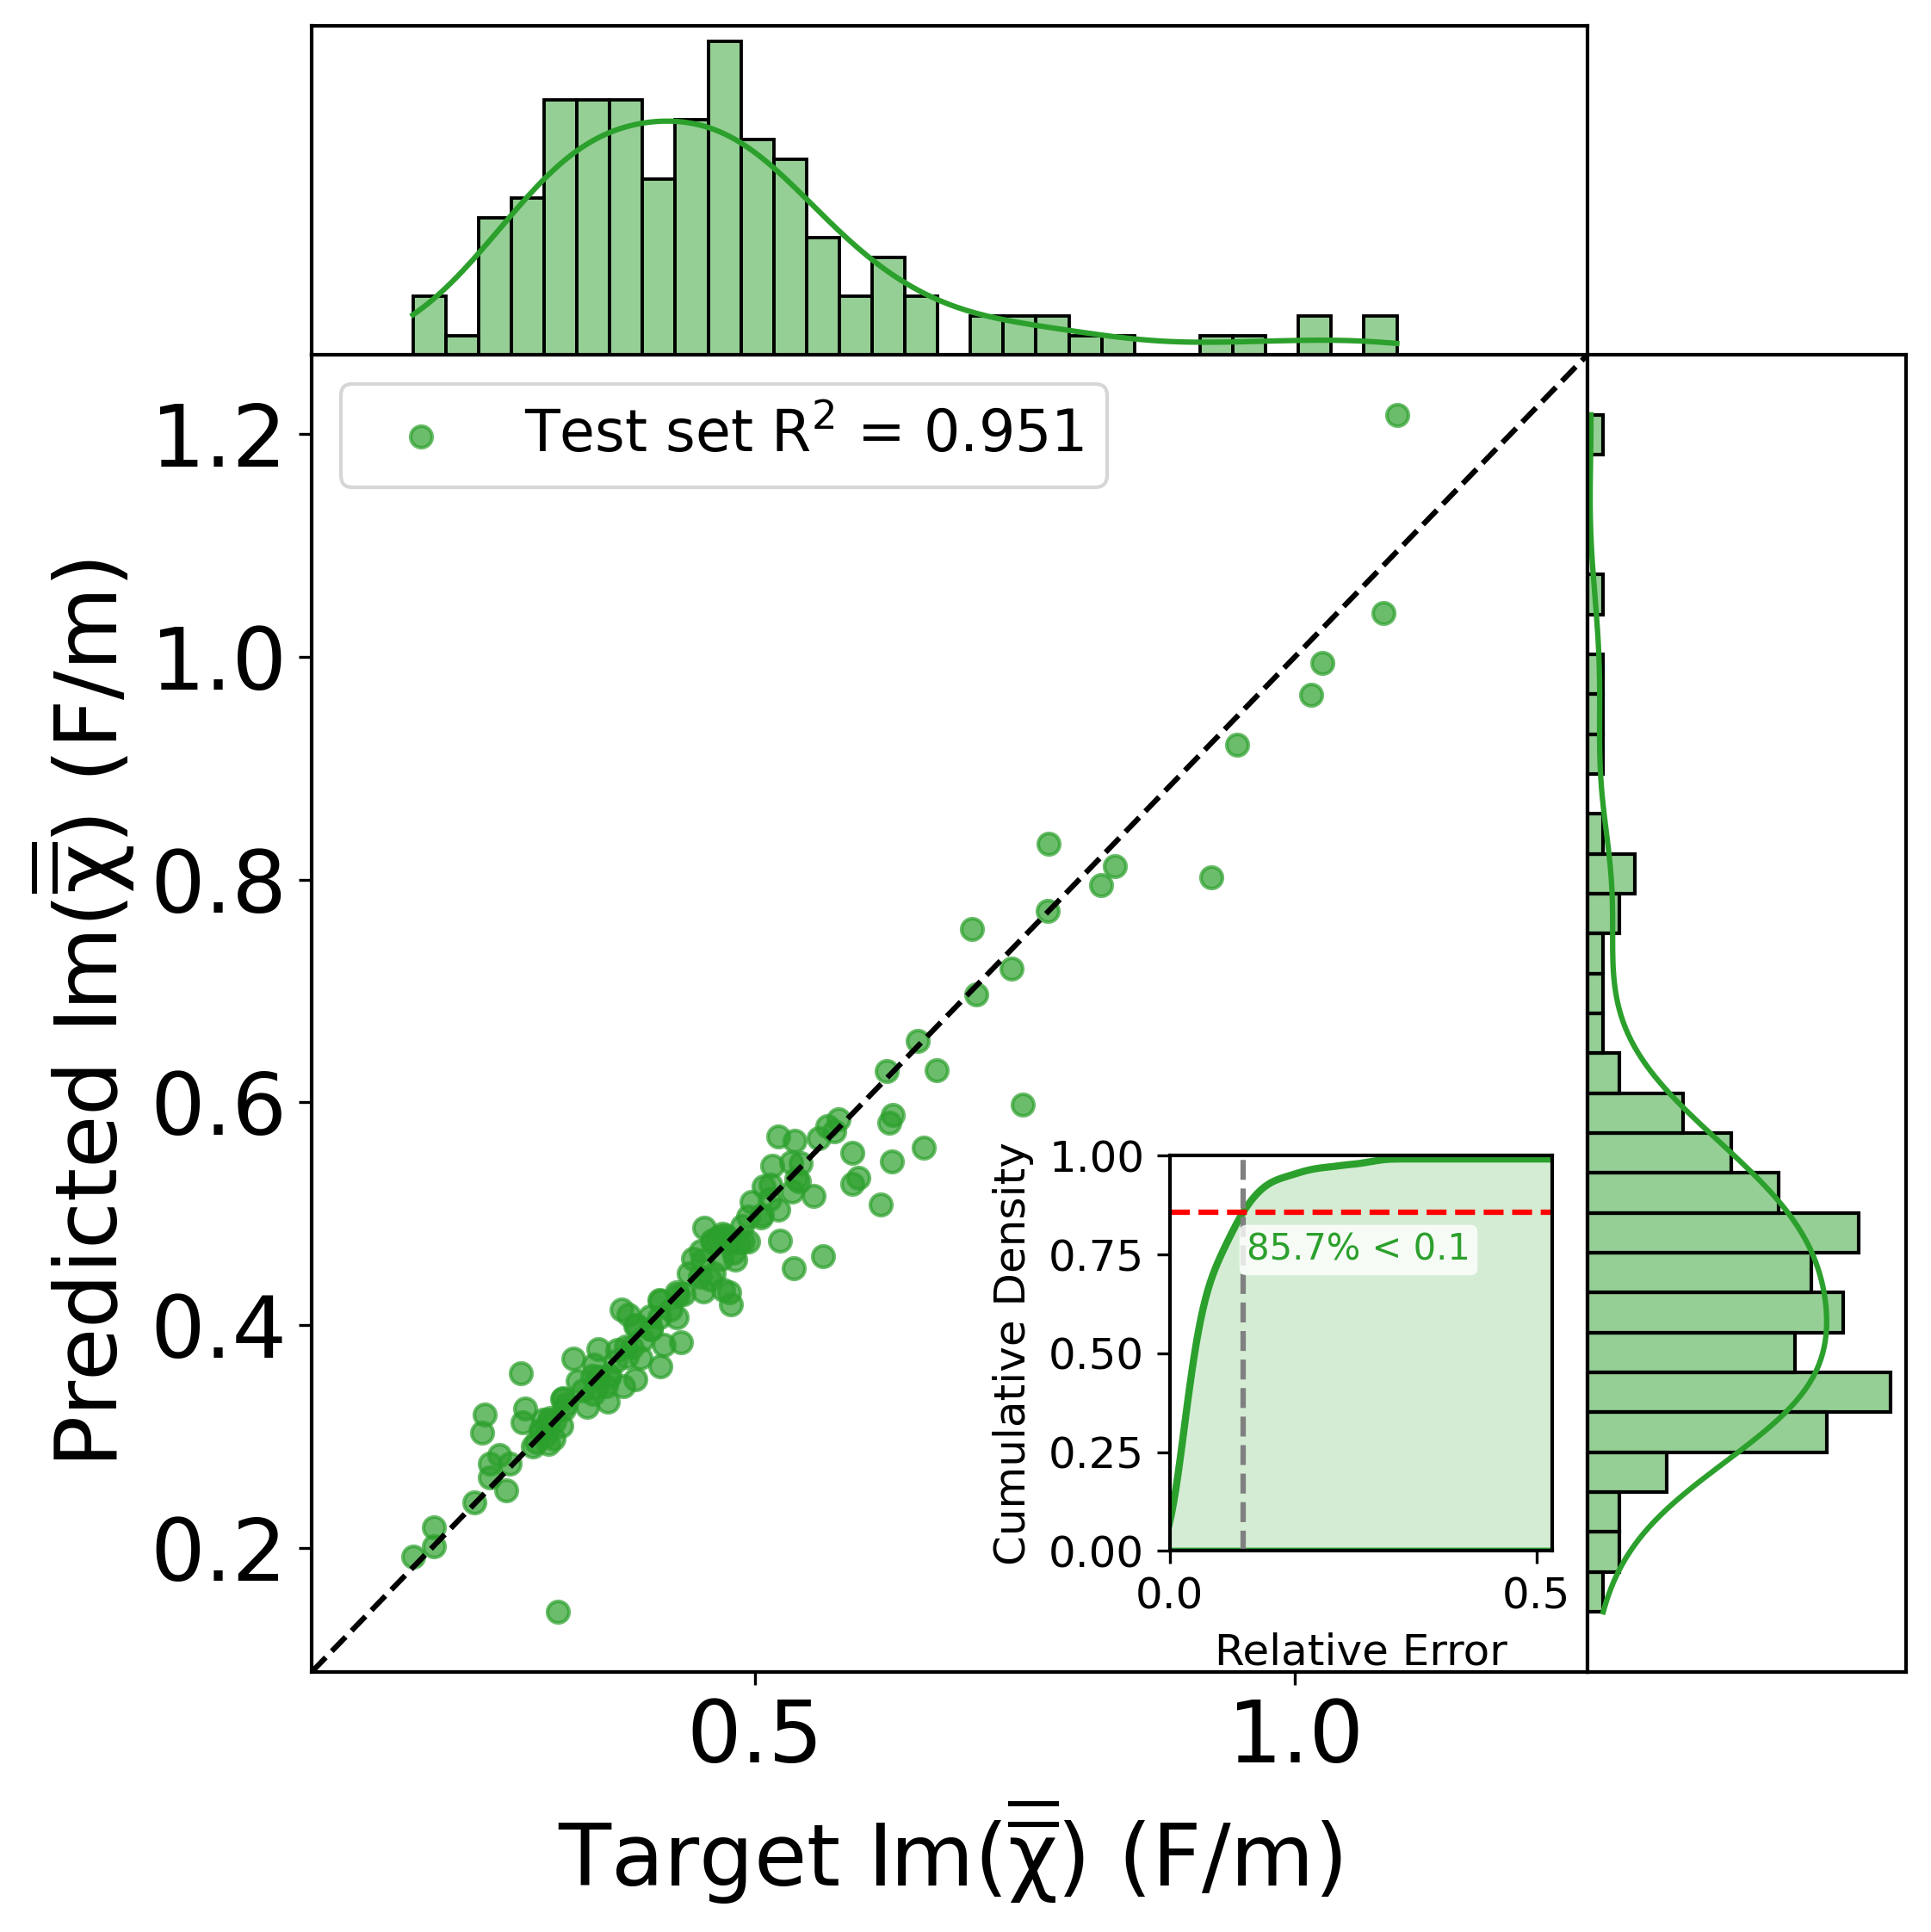

Train:
  R² = 0.9606067
  Mean abs_diff = 16.4628235
Validation:
  R² = 0.9535461
  Mean abs_diff = 22.1930807
Test:
  R² = 0.9512279
  Mean abs_diff = 24.2156332


In [4]:
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams["mathtext.fontset"] = "cm"
fontsize = 24
textsize = 16
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'Liberation Sans', 'sans-serif']
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize 
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.dpi'] = 150       
plt.rcParams['savefig.dpi'] = 300      


splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}


df['split'] = np.nan
for split_name, idx in splits.items():
    df.loc[idx, 'split'] = split_name


df['target_mean'] = df["imag_Permittivity_Matrices_interp"].apply(
    lambda x: np.mean(x, axis=0)  
)
df['pred_mean'] = df["y_pred_cart"].apply(
    lambda x: np.mean(x, axis=0)  
)

def symmetric_tensor_avg(t):
    return np.mean([t[0, 0], t[1, 1], t[2, 2], t[0, 1], t[0, 2], t[1, 2]])

df['target_avg'] = df['target_mean'].apply(symmetric_tensor_avg) # Average over all 9 components
df['pred_avg'] = df['pred_mean'].apply(symmetric_tensor_avg)


# Compute absolute difference between the averages
df['abs_diff_avg'] = np.abs(df['target_avg'] - df['pred_avg'])

test_df = df[df['split'] == 'Test']
target_avg = test_df['target_avg'].values  # Shape: (num_test_samples,)
pred_avg = test_df['pred_avg'].values      # Shape: (num_test_samples,)
abs_diff_avg = test_df['abs_diff_avg'].values  # Shape: (num_test_samples,)


r2 = r2_score(target_avg, pred_avg)
# Create a scatter plot with marginal histograms for the Test set
fig = plt.figure(figsize=(8, 8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], 
                      wspace=0.00, hspace=0.00)

# Define colors
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

# Main scatter plot (average over components)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(target_avg, pred_avg, alpha=0.7, color=colors["Test"], 
                   label=f"Test set $R^2$ = {r2:.3f}")
ax_scatter.set_xlabel(r"Target $Im(\overline{\overline{\chi}}$) (F/m)")
ax_scatter.set_ylabel(r"Predicted $Im(\overline{\overline{\chi}}$) (F/m)")

# Add y = x reference line
min_val = min(min(target_avg), min(pred_avg))
max_val = max(max(target_avg), max(pred_avg))
buffer = (max_val - min_val) * 0.05
min_val -= buffer
max_val += buffer
ax_scatter.set_xlim(min_val, max_val)
ax_scatter.set_ylim(min_val, max_val)
x_vals = np.linspace(min_val, max_val, 100)
ax_scatter.plot(x_vals, x_vals, linestyle='--', color='black')
ax_scatter.legend(fontsize=16, loc='upper left', bbox_to_anchor=(0, 1.0))

# Top histogram (x-axis: True Avg)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(target_avg, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histx)
ax_histx.set_ylabel("")
ax_histx.set_xlabel("")
ax_histx.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histx.tick_params(axis='y', which='both', left=False, labelleft=False)

# Right histogram (y-axis: Predicted Avg)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
sns.histplot(y=pred_avg, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histy)
ax_histy.set_xlabel("")
ax_histy.set_ylabel("")
ax_histy.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histy.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add inset KDE plot for abs_diff_avg (using CDF)
epsilon = 1e-8  # Small value to prevent division by zero
rel_error = np.abs((target_avg - pred_avg) / (np.abs(target_avg) + epsilon))

inset_ax = inset_axes(ax_scatter, width="30%", height="30%", loc='lower right', 
                      bbox_to_anchor=(-0.005, 0.07, 1, 1), bbox_transform=ax_scatter.transAxes)
sns.kdeplot(rel_error, color=colors["Test"], ax=inset_ax, linewidth=2, bw_adjust=0.5, 
            fill=True, cumulative=True, alpha=0.2)
inset_ax.set_xlabel('Relative Error', fontsize=12)  
inset_ax.set_ylabel('Cumulative Density', fontsize=12)
inset_ax.tick_params(axis='both', labelsize=12)
inset_ax.set_xlim(0, max(rel_error) * 0.95)
inset_ax.set_ylim(0, 1)

# Define threshold and compute percentage
threshold = 0.1 # Adjust based on abs_diff_avg range
perc_te = np.mean(rel_error < threshold) * 100
inset_ax.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
inset_ax.axhline(y=perc_te/100, color='red', linestyle='--', linewidth=1.5)
inset_ax.text(threshold+0.005, perc_te/100 - 0.05, f'{perc_te:.1f}% < {threshold}', 
              color=colors["Test"], fontsize=10, ha='left', va='top', 
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

# Adjust layout
plt.tight_layout()
plt.show()

# Optional: Display summary statistics
for split_name in splits:
    split_df = df[df['split'] == split_name]
    split_target_avg = split_df['target_avg'].values
    split_pred_avg = split_df['pred_avg'].values
    split_r2 = r2_score(split_target_avg, split_pred_avg)
    print(f"{split_name}:")
    print(f"  R² = {split_r2:.7f}")
    print(f"  Mean abs_diff = {split_df['abs_diff_avg'].mean() * 1000:.7f}")

# sampled

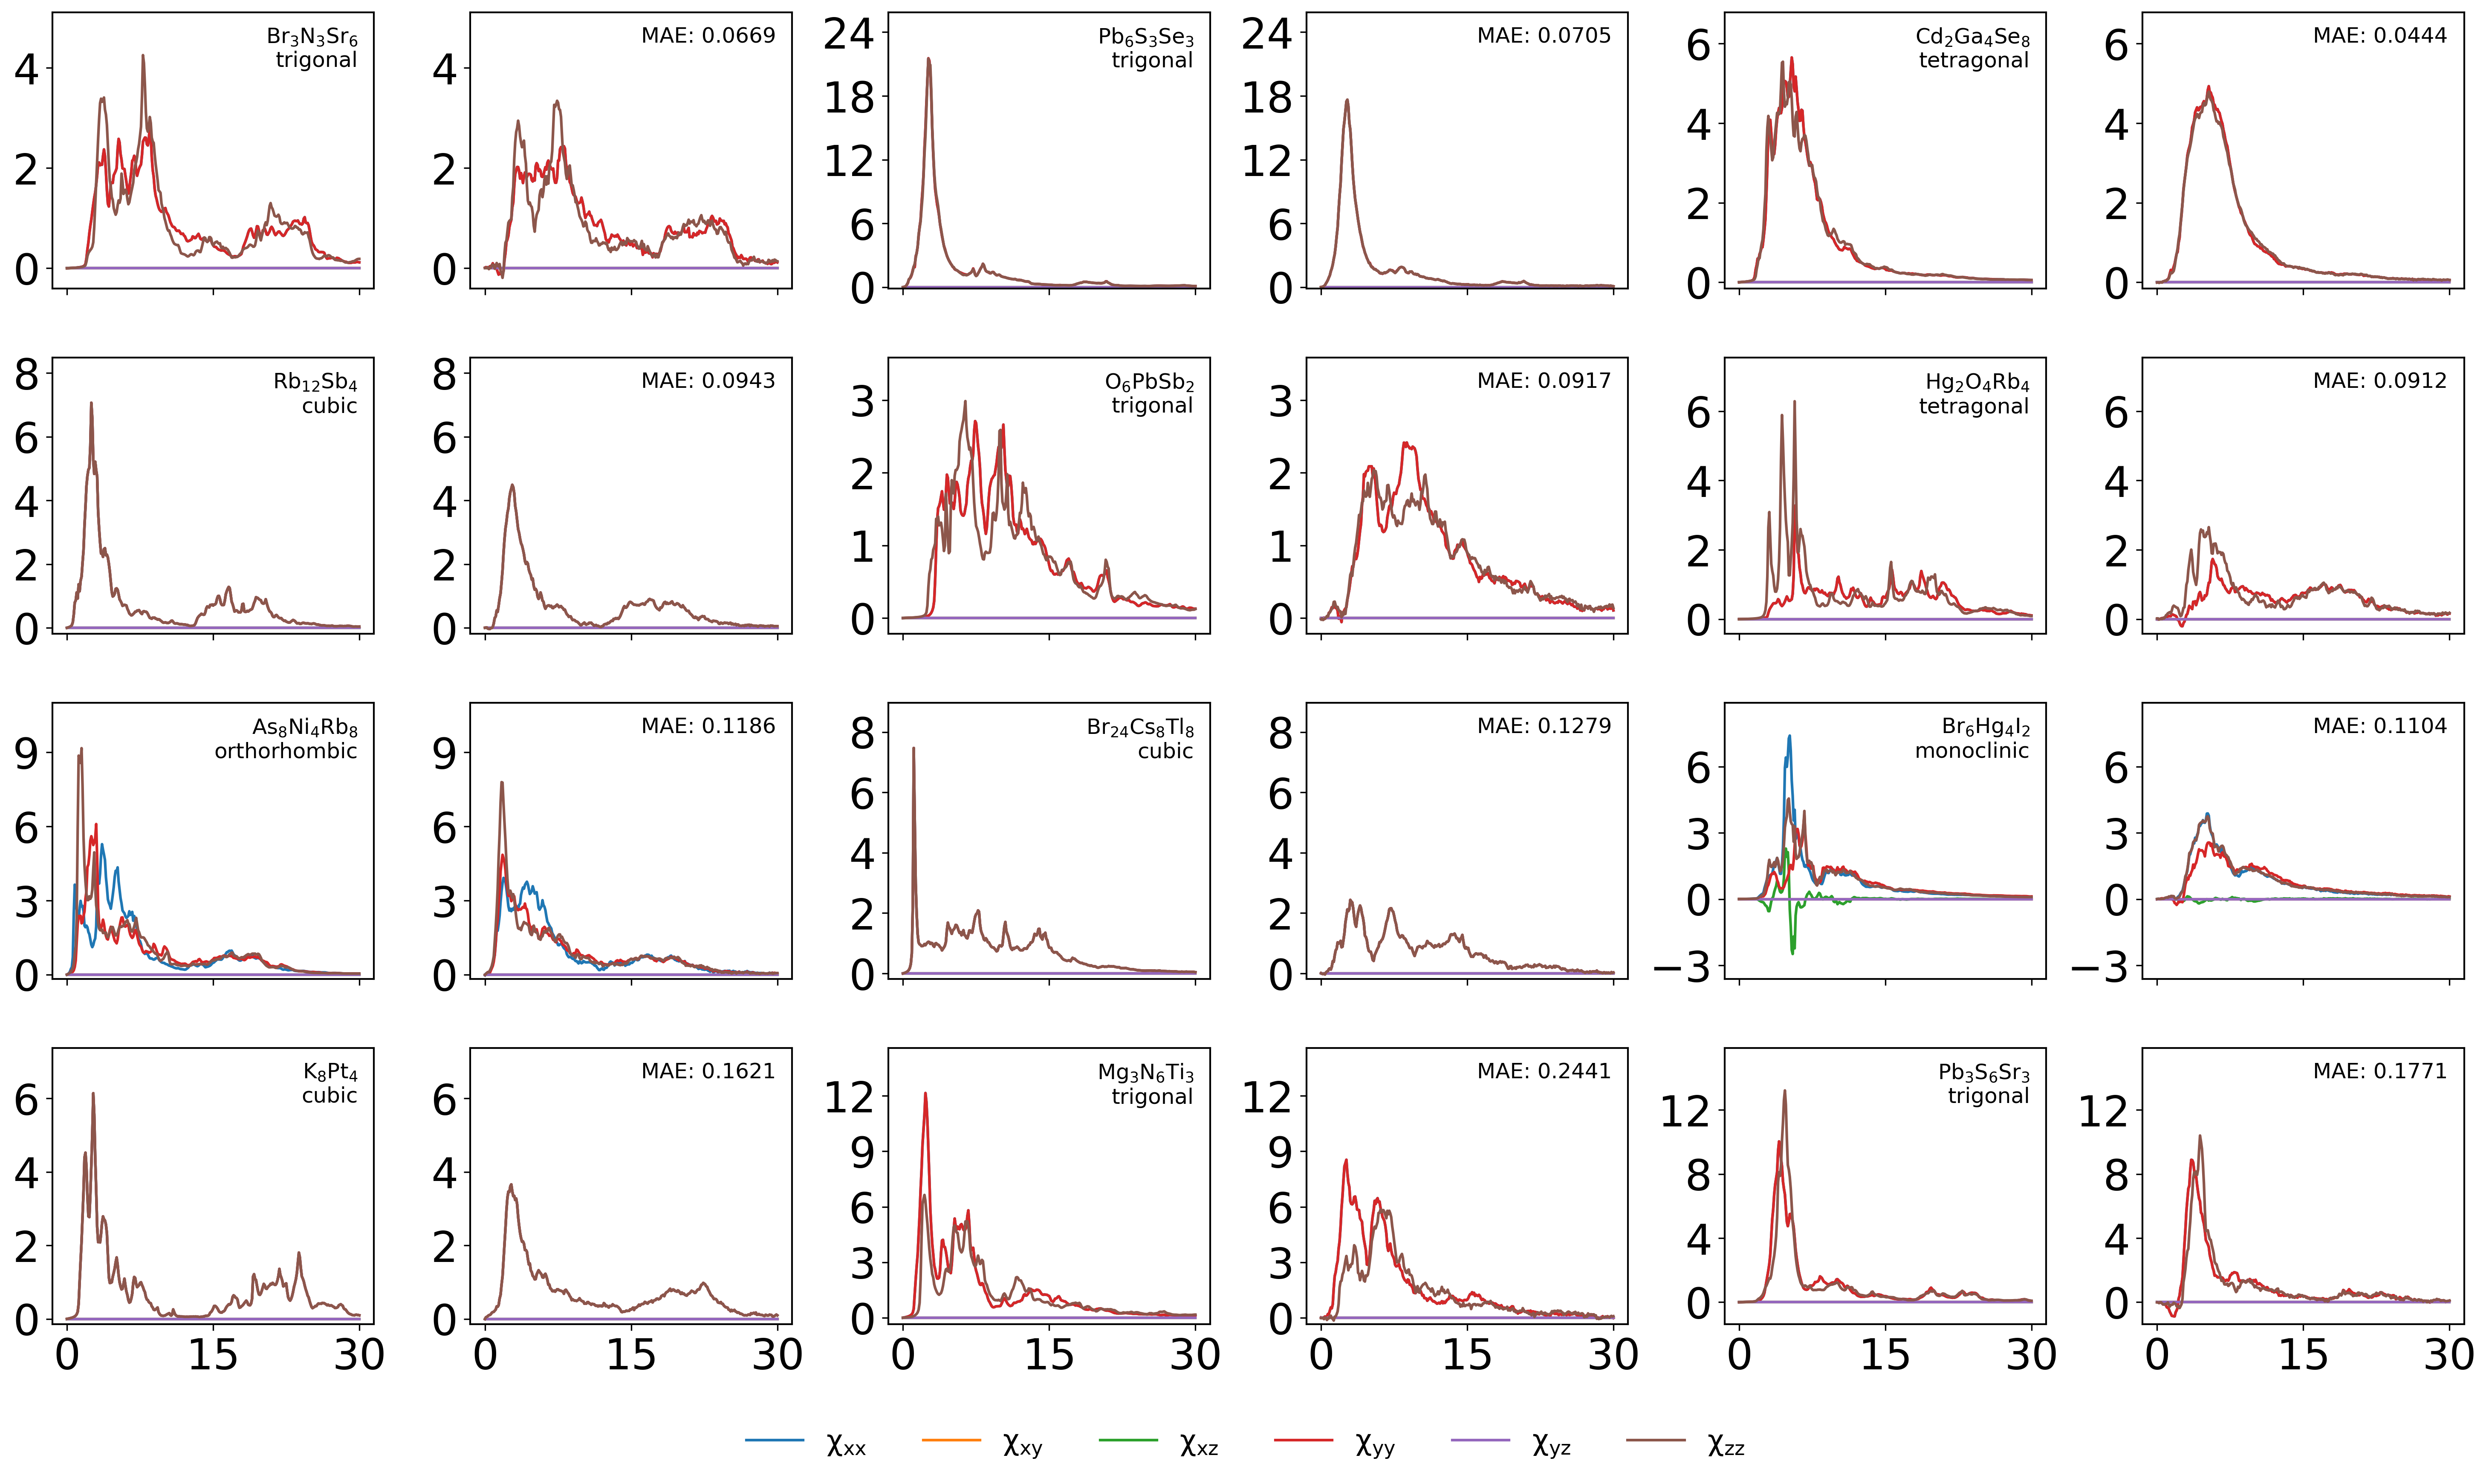

In [5]:
n_samples = 12
def sample_by_mae_quartiles(df, idx_test, n_per_quartile=3):
    """
    Robust quartile sampling from test set by `mae_cart` values.

    Returns:
        List of lists: Each sublist contains indices from one quartile.
    """
    df_test = df.loc[idx_test].copy()
    df_test = df_test.reset_index()

    # Try to divide into 4 bins (quartiles)
    try:
        df_test["mae_quartile"] = pd.qcut(
            df_test["mae_cart"].rank(method="first"), 
            q=4, 
            labels=False,
            duplicates="drop"
        )
    except ValueError as e:
        print("Warning:", e)
        return []

    grouped_indices = []
    for q in range(4):
        q_bin = df_test[df_test["mae_quartile"] == q]
        if len(q_bin) == 0:
            print(f"Skipping quartile {q} due to lack of data.")
            continue
        sampled = q_bin.sample(min(n_per_quartile, len(q_bin)), random_state=42)
        grouped_indices.append(sampled["index"].tolist())

    return grouped_indices

def plot_cartesian_tensor_comparison_by_quartile(df, grouped_idx, column_name, title_prefix=""):
    """
    Plots 3 samples per quartile in 4 rows (1 row per quartile), 6 subplots per row.

    Parameters:
    - grouped_idx: List of 4 sublists (each from a quartile)
    """
    xyz_list = ['x', 'y', 'z']
    tensor_components = [f"$\chi_{{{xyz_list[a]}{xyz_list[b]}}}$" for a in range(3) for b in range(a, 3)]
    total_samples = sum(len(g) for g in grouped_idx)

    fig, axes = plt.subplots(4, 6, figsize=(20, 12), dpi=300, sharex=True)
    axes = axes.reshape(4, 6)

    handles, labels = [], []
    sample_idx = 0

    for row_idx, quartile_group in enumerate(grouped_idx):
        for col_idx, idx_val in enumerate(quartile_group):
            ds_row = df.loc[idx_val]
            omega = ds_row["energies_interp"]
            real = ds_row[column_name]
            pred = ds_row["y_pred_cart"]
            formula = format_chemical_formula(ds_row["formula"])
            system = ds_row["crystal_system"]
            mae = ds_row["mae_cart"]

            y_min = min(real.min(), pred.min())
            y_max = max(real.max(), pred.max())

            ax_real = axes[row_idx, col_idx * 2]
            ax_pred = axes[row_idx, col_idx * 2 + 1]

            for i, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
                h, = ax_real.plot(omega, real[:, a, b], label=tensor_components[i])
                ax_pred.plot(omega, pred[:, a, b])
                if sample_idx == 0:
                    handles.append(h)
                    labels.append(tensor_components[i])

            for ax in (ax_real, ax_pred):
                ax.set_ylim((y_min - 0.1) * 1.4, y_max * 1.2)
                ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
                ax.set_xticks([])

            ax_real.text(0.95, 0.95, f"${formula}$\n{system}",
                         transform=ax_real.transAxes, fontsize=12, va='top', ha='right',
                         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            ax_pred.text(0.95, 0.95, f"MAE: {mae:.4f}",
                         transform=ax_pred.transAxes, fontsize=12, va='top', ha='right',
                         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            sample_idx += 1

    for ax in axes[-1, :]:
        ax.set_xticks(np.linspace(min(omega), max(omega), 3))

    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.01), ncol=6, fontsize=16, frameon=False)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.subplots_adjust(wspace=0.3, hspace=0.25)

    os.makedirs("../pngs", exist_ok=True)
    fig.savefig(f"../pngs/{title_prefix}_quartile_grid.png", dpi=300)
    plt.show()
grouped_idx = sample_by_mae_quartiles(df, idx_test, n_per_quartile=3)
plot_cartesian_tensor_comparison_by_quartile(df, grouped_idx, column_name=column, title_prefix="mae_quartiles")

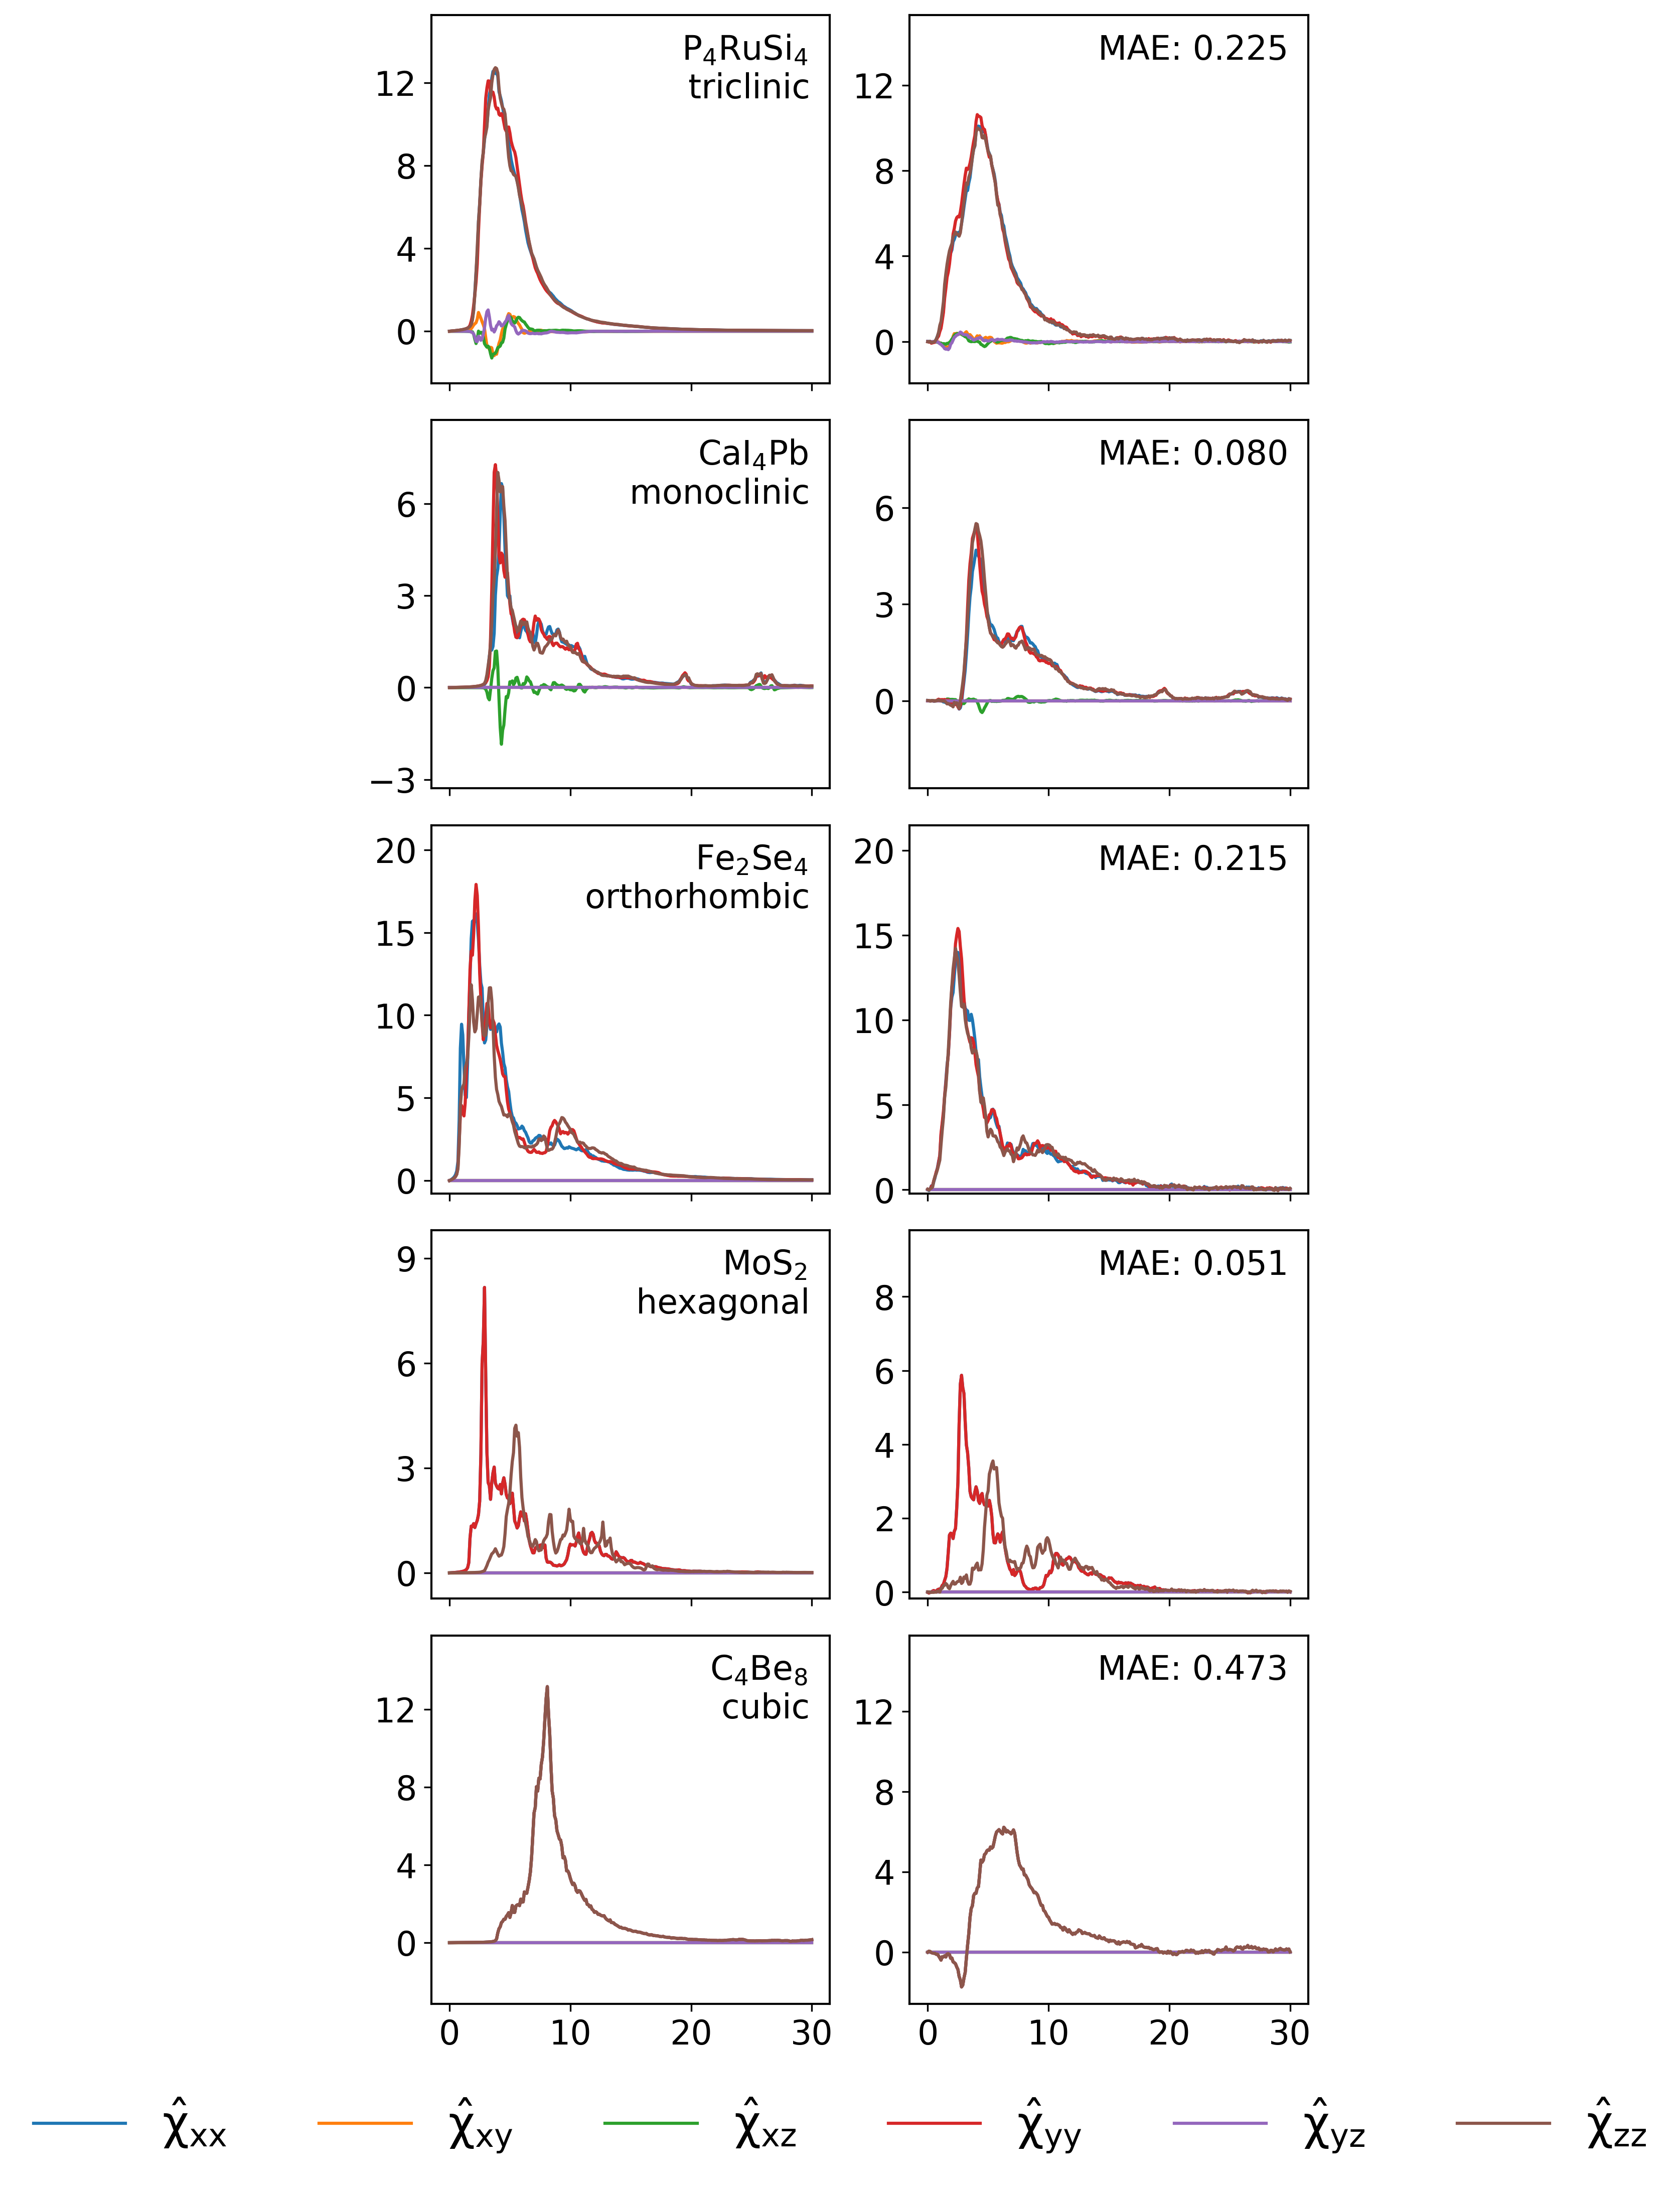

In [6]:
def get_one_sample_per_crystal_system(df, idx_test, target_systems):
    """
    Returns one index per crystal system from the test set, ordered from low to high symmetry.

    Parameters:
    - df: Full dataframe with 'crystal_system' column.
    - idx_test: List of indices belonging to the test set.
    - target_systems: List of crystal systems to include.

    Returns:
    - List of indices corresponding to one sample per crystal system, ordered by symmetry.
    """
    import random
    idx_test = list(idx_test)  # <-- COPY here, don't modify input!
    # random.seed(11)
    random.seed(20)
    random.shuffle(idx_test)

    # Define symmetry order from low to high
    symmetry_order = [
        "triclinic",
        "monoclinic",
        "orthorhombic",
        "tetragonal",
        "trigonal",
        "hexagonal",
        "cubic",
    ]

    # Filter the list to only those in target_systems, in the desired order
    ordered_targets = [s for s in symmetry_order if s in target_systems]

    # Create a lookup: crystal_system -> index
    system_to_index = {}
    seen_systems = set()

    for idx in idx_test:
        system = df.loc[idx, "crystal_system"]
        if system in ordered_targets and system not in seen_systems:
            system_to_index[system] = idx
            seen_systems.add(system)
        if len(seen_systems) == len(ordered_targets):
            break

    # Return indices in the desired symmetry order
    return [system_to_index[system] for system in ordered_targets if system in system_to_index]

    
    return selected_indices
def plot_cartesian_tensor_comparison(df, idx, column_name, title_prefix="", n=3):
    """
    Plots multiple side-by-side line plots comparing predicted vs. real Cartesian tensors 
    in a more compact horizontal layout with minimal white space.

    Parameters:
    - df: Pandas DataFrame containing 'y_pred_cart' (predictions), 
          'real_Permittivity_Matrices_interp' (targets), and 'energies_interp'.
    - idx: List or array of indices to consider (e.g., idx_train, idx_test).
    - title_prefix: Prefix to be added to the plot title.
    - n: Number of samples to plot.
    """
    # Filter DataFrame based on provided indices
    ds = df.iloc[idx].reset_index(drop=True)

    # Define component labels
    xyz_list = ['x', 'y', 'z']
    tensor_components = [f"$\hat{{\chi}}_{{{xyz_list[a]}{xyz_list[b]}}}$" for a in range(3) for b in range(a, 3)]

    # Define subplot grid layout
    n_rows = 5
    n_cols = 2  
    # Adjust figure size to reduce white space
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows), dpi=300, sharex=True)
    axes = axes.ravel()  # Flatten axes array for easy iteration

    handles, labels = [], []

    for i, sample_idx in enumerate(idx[:n]):  # Directly loop over provided idx
        material_id = ds.iloc[i]['mp_id']
        mae_cart = ds.iloc[i]['mae_cart']
        
        crystal_system = ds.iloc[i]['crystal_system']
        formula = ds.iloc[i]['formula']
        omega = ds["energies_interp"].iloc[i]
        formatted_formula = format_chemical_formula(formula)
        real_permittivity = ds[column_name].iloc[i]  # (num_energies, 3, 3)
        pred_permittivity = ds["y_pred_cart"].iloc[i]  # (num_energies, 3, 3)
        
        y_min = min(real_permittivity.min(), pred_permittivity.min())
        y_max = max(real_permittivity.max(), pred_permittivity.max())
        
        # Left subplot: Real permittivity
        ax_real = axes[2 * i]  # Every even index is real data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            h, = ax_real.plot(omega, real_permittivity[:, a, b], label=tensor_components[idx], linestyle='-')
            if i == 0:  # Collect legend items only from the first plot
                handles.append(h)
                labels.append(tensor_components[idx])
        if column_name =="real_Permittivity_Matrices_interp":
            ax_real.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_real.set_ylim((y_min-0.5) * 1.4, y_max * 1.2)
        ax_real.text(0.95, 0.95, f"${formatted_formula}$ \n {crystal_system}", 
             transform=ax_real.transAxes, fontsize=16, verticalalignment='top', 
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        ax_real.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

        # Right subplot: Predicted permittivity
        ax_pred = axes[2 * i + 1]  # Every odd index is predicted data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            ax_pred.plot(omega, pred_permittivity[:, a, b], linestyle='-')
        if column_name =="real_Permittivity_Matrices_interp":
            ax_pred.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_pred.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)

        text_str = (
            f"{'MAE:':<1} {mae_cart:>4.3f}\n"
        )

        # Add the text to the subplot
        ax_pred.text(
            0.95, 0.95,  # Position in axes coordinates (top-right)
            text_str,
            transform=ax_pred.transAxes,
            fontsize=16,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )
        ax_pred.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        
    # Remove x-labels from individual subplots
    for ax in axes:
        ax.set_xticks([])
        ax.tick_params(axis='y', labelsize=16)  # <-- Set the x-tick label size here
    for ax in axes[-n_cols:]:  
        ax.set_xticks(np.linspace(min(omega), max(omega), 4))
        ax.tick_params(axis='x', labelsize=16)  # <-- Set the x-tick label size here

    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.01), ncol=6, fontsize=22, frameon=False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
    plt.subplots_adjust(wspace=0.2, hspace=0.1)  

    os.makedirs("../pngs", exist_ok=True)
    save_path = f"../pngs/{title_prefix}_cart_spectra.png"
    fig.savefig(save_path, dpi=300)

    plt.show()

target_systems = ['triclinic', 'monoclinic', 'orthorhombic', 'hexagonal', 'cubic']
representative_idx = get_one_sample_per_crystal_system(df, idx_test, target_systems)

# Then pass it to your plotting function
plot_cartesian_tensor_comparison(df, representative_idx, column_name=column, title_prefix="five_crystal_systems", n=5)



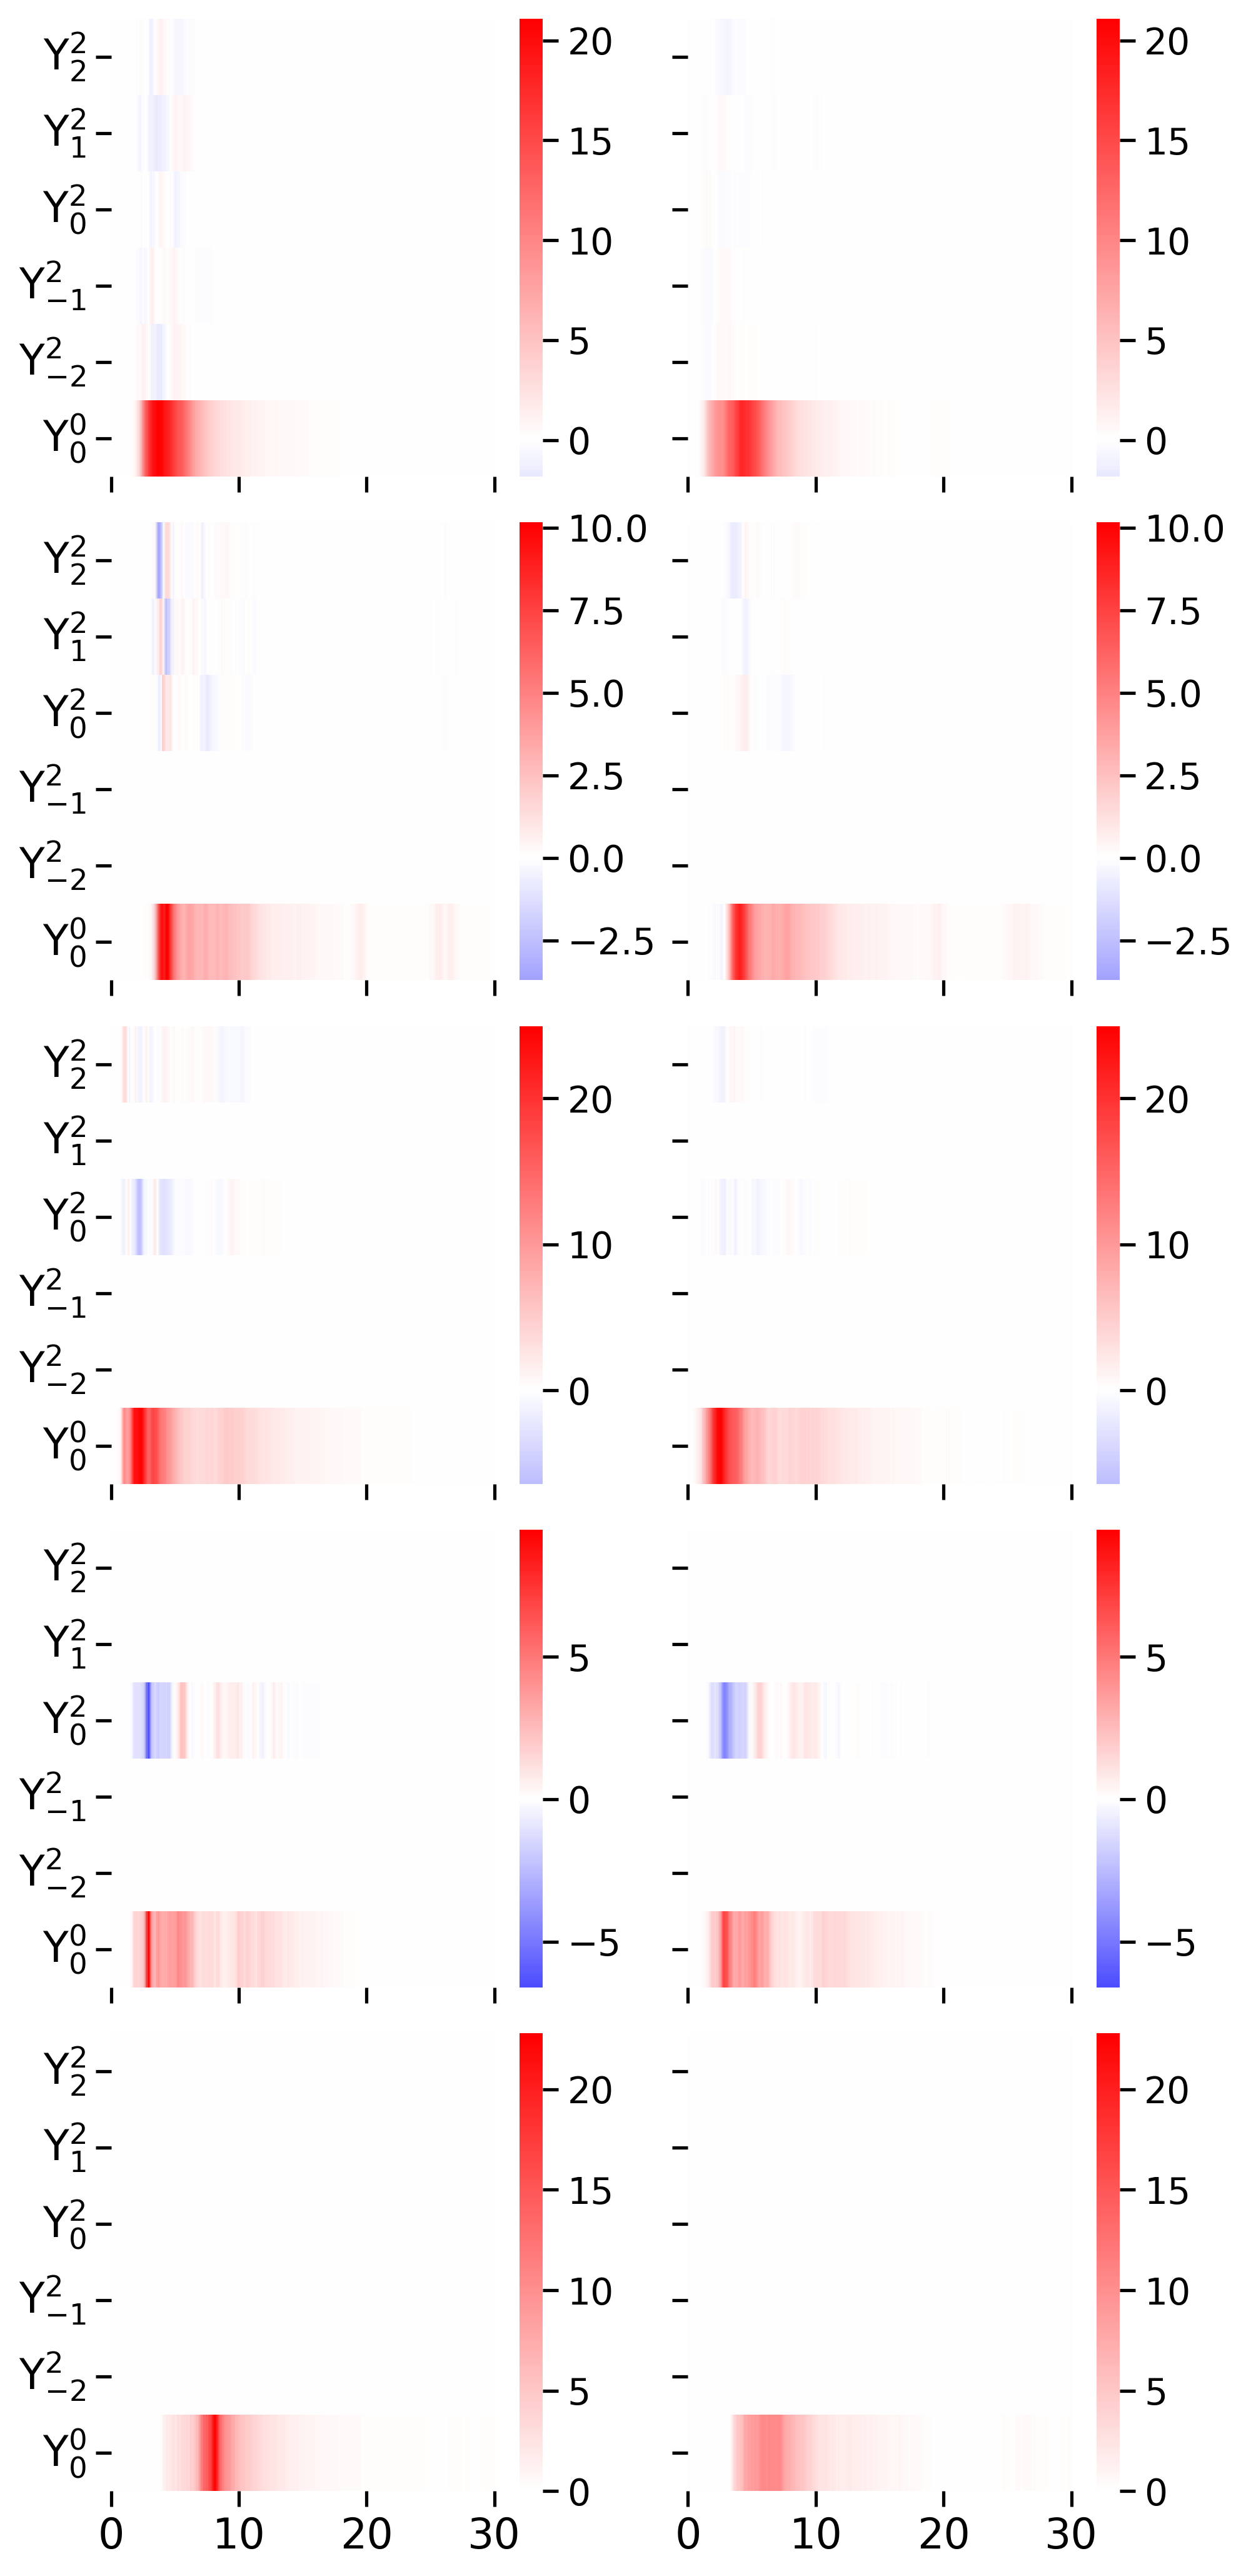

In [7]:
def plot_spherical_harmonics_comparison(df, idx, column_name, title_prefix="", n=4):
    """
    Plots heatmaps comparing target spherical harmonics with predicted spherical harmonics for multiple samples
    in a more compact layout (e.g., 4 rows × multiple columns instead of a single wide row).

    Parameters:
    - df: Pandas DataFrame containing 'sph_coefs' (targets), 'y_pred_sph' (predictions), 'mse'.
    - idx: List or array of indices to consider (e.g., idx_train, idx_test).
    - title_prefix: Prefix to be added to the plot title (e.g., Material ID).
    - n: Number of samples to plot.
    """
    # Filter DataFrame based on provided indices
    from e3nn.io import CartesianTensor
    
    with sns.plotting_context("notebook", font_scale=2):
        ct = CartesianTensor("ij=ji")
        ds = df.iloc[idx].reset_index(drop=True)

        # Extract energy grid (assume shared for all)
        omega = df["energies_interp"].iloc[0]

        # Define subplot grid layout
        # n_rows = 4  # Fixed number of rows
        # n_cols = math.ceil(n / n_rows) * 2  # Ensures space for real & predicted pairs
        n_rows = 5
        n_cols = 2
        # Setup figure with multiple rows & columns for compact layout
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows), sharex=True, sharey=True, dpi=300)
        axes = axes.ravel()  # Flatten axes array for easy iteration

        # Spherical harmonic component labels
        component_ticks = [r"$Y^2_2$", r"$Y^2_{1}$", r"$Y^2_0$", r"$Y^2_{-1}$", r"$Y^2_{-2}$", r"$Y^0_0$"]
        # component_ticks = [
        #     r"",
        #     r"",
        #     r"",
        #     r"",
        #     r"",
        #     r""
        # ]

        for i, sample_idx in enumerate(idx[:n]):  # Use provided indices directly
            material_id = ds.iloc[i]['mp_id']
            crystal_system = ds.iloc[i]['crystal_system']
            real_permittivity = ds[column_name].iloc[i]  # (num_energies, 3, 3)
            pred_permittivity = ds["y_pred_cart"].iloc[i]  # (num_energies, 3, 3)
            perm = torch.tensor([1, 2, 0])  # Permutation: x->2, y->0, z->1

            # Convert to torch tensors if not already
            real_permittivity = torch.tensor(real_permittivity) if not torch.is_tensor(real_permittivity) else real_permittivity
            pred_permittivity = torch.tensor(pred_permittivity) if not torch.is_tensor(pred_permittivity) else pred_permittivity

            # Permute the 3x3 dimensions (axes 1 and 2)
            real_permittivity_permuted = real_permittivity[:, perm, :][:, :, perm]  # Shape: [201, 3, 3]
            pred_permittivity_permuted = pred_permittivity[:, perm, :][:, :, perm]  # Shape: [201, 3, 3]

            real_sph = ct.from_cartesian(real_permittivity_permuted)
            pred_sph = ct.from_cartesian(pred_permittivity_permuted)

            # Extract target and prediction, then transpose & reverse for correct visualization
            X_irrep_target = real_sph.numpy().T[::-1, :]
            X_irrep_pred = pred_sph.numpy().T[::-1, :]
            vmin = X_irrep_target.min()
            vmax = X_irrep_target.max()
            # Left: Target heatmap
            ax_target = axes[2 * i]
            sns.heatmap(X_irrep_target, cmap='bwr', center=0, ax=ax_target,
                        yticklabels=component_ticks, xticklabels=50,
                        vmin=vmin, vmax=vmax)

            ax_target.tick_params(axis='x', rotation=0, labelsize=16)  
            ax_target.tick_params(axis='y', rotation=0, labelsize=16)  

            # Right: Predicted heatmap
            ax_pred = axes[2 * i + 1]
            sns.heatmap(X_irrep_pred, cmap='bwr', center=0, ax=ax_pred,
                        yticklabels=component_ticks, xticklabels=50,
                        vmin=vmin, vmax=vmax)

            ax_pred.tick_params(axis='x', rotation=0, labelsize=16)  
            ax_pred.tick_params(axis='y', rotation=0, labelsize=16)  

        # Set x-axis ticks at reasonable intervals
        num_omega = len(omega)
        tick_indices = np.linspace(0, num_omega - 1, 4, dtype=int)  
        tick_labels = [int(round(omega[idx])) for idx in tick_indices]  

        for ax in axes[:2 * n]:
            if ax.collections:  
                cbar = ax.collections[0].colorbar
                cbar.ax.tick_params(labelsize=14)  # <-- make colorbar tick labels smaller
        for ax in axes[:2 * n]:  
            ax.set_xticks(tick_indices)
            ax.set_xticklabels(tick_labels)

        plt.tight_layout(rect=[0, 0.05, 1, 1])  
        plt.subplots_adjust(wspace=0.2, hspace=0.1)  
        os.makedirs("../pngs", exist_ok=True)
        save_path = f"../pngs/{title_prefix}_spectra.png"
        fig.savefig(save_path, dpi=300)

        plt.show()

plot_spherical_harmonics_comparison(df, representative_idx, column, title_prefix="testing_set", n=5)


In [8]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor  # Import the converter
import numpy as np

sym_prec = 1e-2
tolerance = 1e-6

all_masks = []
test_df = df[df['split'] == 'Test']

for index, row in test_df.iterrows():
    # Convert ASE Atoms object to pymatgen Structure
    ase_atoms = row.symmetrized_structure  # This is your ASE Atoms object
    pymatgen_structure = AseAtomsAdaptor.get_structure(ase_atoms)
    
    # Now use the pymatgen Structure with SpacegroupAnalyzer
    sga_primitive = SpacegroupAnalyzer(pymatgen_structure, symprec=sym_prec)
    refined_structure = sga_primitive.get_refined_structure()
    refined_sga = SpacegroupAnalyzer(refined_structure, symprec=sym_prec)
    symmetry_operations = refined_sga.get_symmetry_operations(cartesian=True)

    x = np.ones([3, 3])
    mask = np.zeros([3, 3])
    for op in symmetry_operations:
        R = op.rotation_matrix 
        mask += R @ x @ R.T
    mask /= len(symmetry_operations)
    all_masks.append(mask) 

    spectra = row["y_pred_cart"]  # Shape: (301, 3,3)
    # spectra = row["imag_Permittivity_Matrices_interp"]

    violations = []
    for i in range(spectra.shape[0]):  # Loop over omega
        S_matrix = spectra[i] # Reshape (9,) -> (3,3)
        # Check symmetry constraint
        residuals = S_matrix * (1 - mask)  # Keep only the disallowed values
        max_deviation = np.max(np.abs(residuals))  # Max deviation outside mask

        if max_deviation > tolerance:
            violations.append((i, max_deviation))
    sys = row["crystal_system"]
    formula = row["formula"]
    split = row["split"]
    # Print results
    if not violations:
        # print(f"Material {row['mp_id']} pass check")
        continue
    else:
        print(f"Material @ {index} {row['mp_id']} violates symmetry in {len(violations)} cases. {sys}. {formula} {split}")
        # for index, dev in violations[:5]:  # Print first few violations
            # print(f"  - Row {index}: max deviation = {dev:.5e}")

# test_df["symmetry_mask"] = all_masks


In [9]:
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count  

def kramers_kronig_tensor(omega_vals, imag_tensor):
    N = len(omega_vals)
    real_tensor = np.zeros_like(imag_tensor)

    for i in range(3):
        for j in range(i, 3):
            chi_im_vals = imag_tensor[:, i, j]
            chi_re_vals = np.zeros(N)

            for k, omega in enumerate(omega_vals):
                integrand = np.zeros(N)
                for l, omega_p in enumerate(omega_vals):
                    if l != k: # Skip the singularity when omega' = omega
                        integrand[l] = (omega_p * chi_im_vals[l]) / (omega_p**2 - omega**2)
                integral = np.trapz(integrand, omega_vals)
                chi_re_vals[k] = (2 / np.pi) * integral

            real_tensor[:, i, j] = chi_re_vals
            if i != j:
                real_tensor[:, j, i] = chi_re_vals
    return real_tensor

def process_row(row_dict):
    row = row_dict.copy()
    imag_permittivity = row["imag_Permittivity_Matrices_interp"]
    pred_imag_permittivity = row["y_pred_cart"]
    omega = row["energies_interp"]

    omega = np.where(omega == 0, np.finfo(float).eps, omega)
    
    real_permittivity = kramers_kronig_tensor(omega, imag_permittivity)
    pred_real_permittivity = kramers_kronig_tensor(omega, pred_imag_permittivity)

    permittivity_complex = real_permittivity + 1j * imag_permittivity
    conductivity_complex = -1j * permittivity_complex / omega[:, np.newaxis, np.newaxis]

    pred_permittivity_complex = pred_real_permittivity + 1j * pred_imag_permittivity
    pred_conductivity_complex = -1j * pred_permittivity_complex / omega[:, np.newaxis, np.newaxis]

    row["conductivity_complex"] = conductivity_complex
    row["pred_conductivity_complex"] = pred_conductivity_complex
    return row

# --- Parallelize over rows ---
num_workers = min(cpu_count(), len(df))  # Limit workers to available CPU cores

def parallel_process_df(df, n_workers=None):
    rows = df.to_dict(orient="records")
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_row, rows))
    return pd.DataFrame(results)

# Usage:
df = parallel_process_df(df)

Test


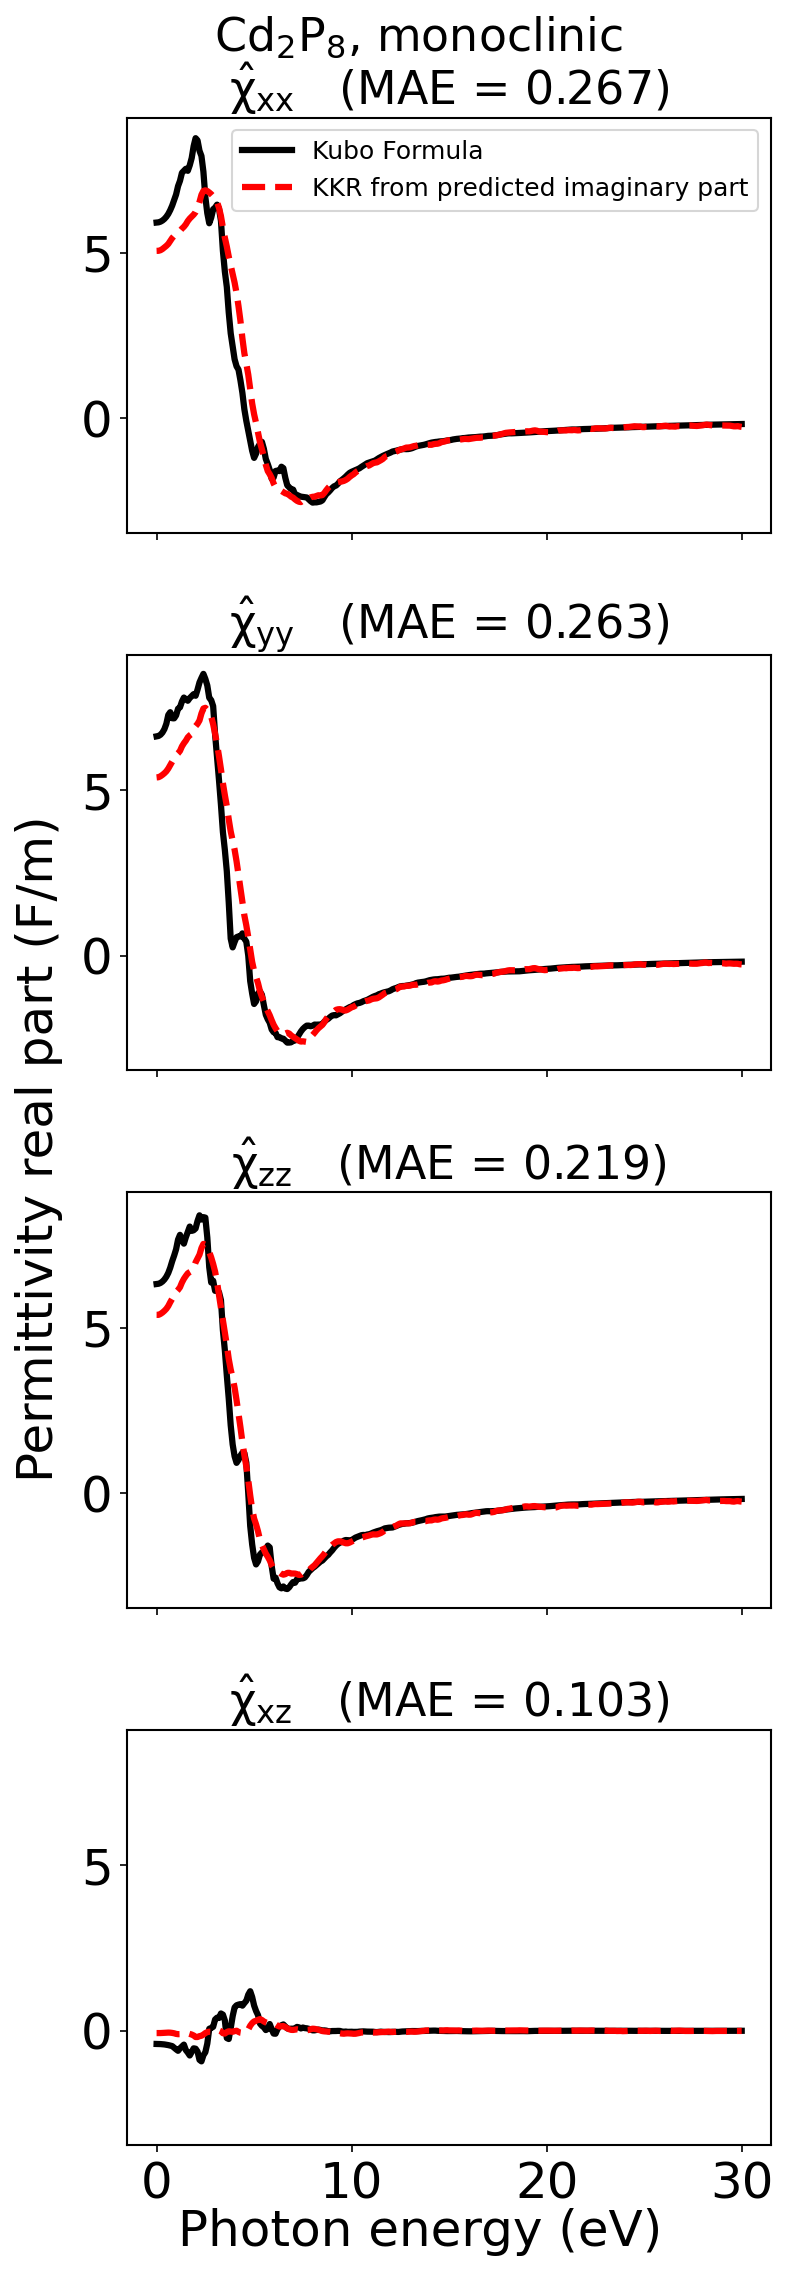

In [10]:
# Choose a row
row = df[df["formula"] == "Cd2P8"].iloc[0]
print(row.split)

# Extract data
omega = row.omega
omega_interp = row.energies_interp

imag_permittivity = row["y_pred_cart"]
real_permittivity = interpolate_matrix(row["real_symmetrized_permittivity"], omega)
real_permittivity_kkr = kramers_kronig_tensor(omega_interp, imag_permittivity)

# Settings
xyz_list = ['x', 'y', 'z']
fontsize = 20
figsize = (6, 18)
threshold = 1e-4
zoomed_out_ylim = 5e-1

# Define which components to show: e.g., xx, yy, zz, xz
components_to_plot = [(0, 0), (1, 1), (2, 2), (0, 2)]

# Set up subplots: 4 vertically stacked
fig, axes = plt.subplots(len(components_to_plot), 1, figsize=figsize, sharex=True, sharey= True, dpi = 150)
if len(components_to_plot) == 1:
    axes = [axes]  # ensure iterable

lines = []
labels = []
maes = []

for ax, (i, j) in zip(axes, components_to_plot):
    y1 = real_permittivity[:, i, j]
    y2 = real_permittivity_kkr[:, i, j]

    l1, = ax.plot(omega_interp, y1, color='black', label='Kubo Formula', linewidth = 3)
    l2, = ax.plot(omega_interp, y2, linestyle='--', color='red', label='KKR from predicted imaginary part',linewidth = 3)

    y_vals = np.concatenate([y1, y2])
    max_val = np.max(np.abs(y_vals))

    if max_val < threshold:
        ax.set_ylim(-zoomed_out_ylim, zoomed_out_ylim)

    mae = np.mean(np.abs(y1 - y2))
    maes.append(mae)

    comp_label = rf"$\hat{{\chi}}_{{{xyz_list[i]}{xyz_list[j]}}}$"
    ax.set_title(f"{comp_label}   (MAE = {mae:.3f})", fontsize=fontsize + 2)
    if len(lines) == 0:
        # Save handles & labels for completeness (optional)
        lines.extend([l1, l2])
        labels.extend([l.get_label() for l in (l1, l2)])
        
        # Put the legend in a less busy spot for the first subplot
        ax.legend(loc='upper right', fontsize= 12, frameon=True)


# Global info
formula = format_chemical_formula(row["formula"])
crystal_sys = row["crystal_system"]
global_mae = np.mean(maes)

fig.suptitle(rf"${formula}$, {crystal_sys} ", fontsize=fontsize + 2, x = 0.55,  y=0.92)
fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 4, y=0.09, x = 0.55)
fig.supylabel("Permittivity real part (F/m)", fontsize=fontsize + 4, x = 0.1)


plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

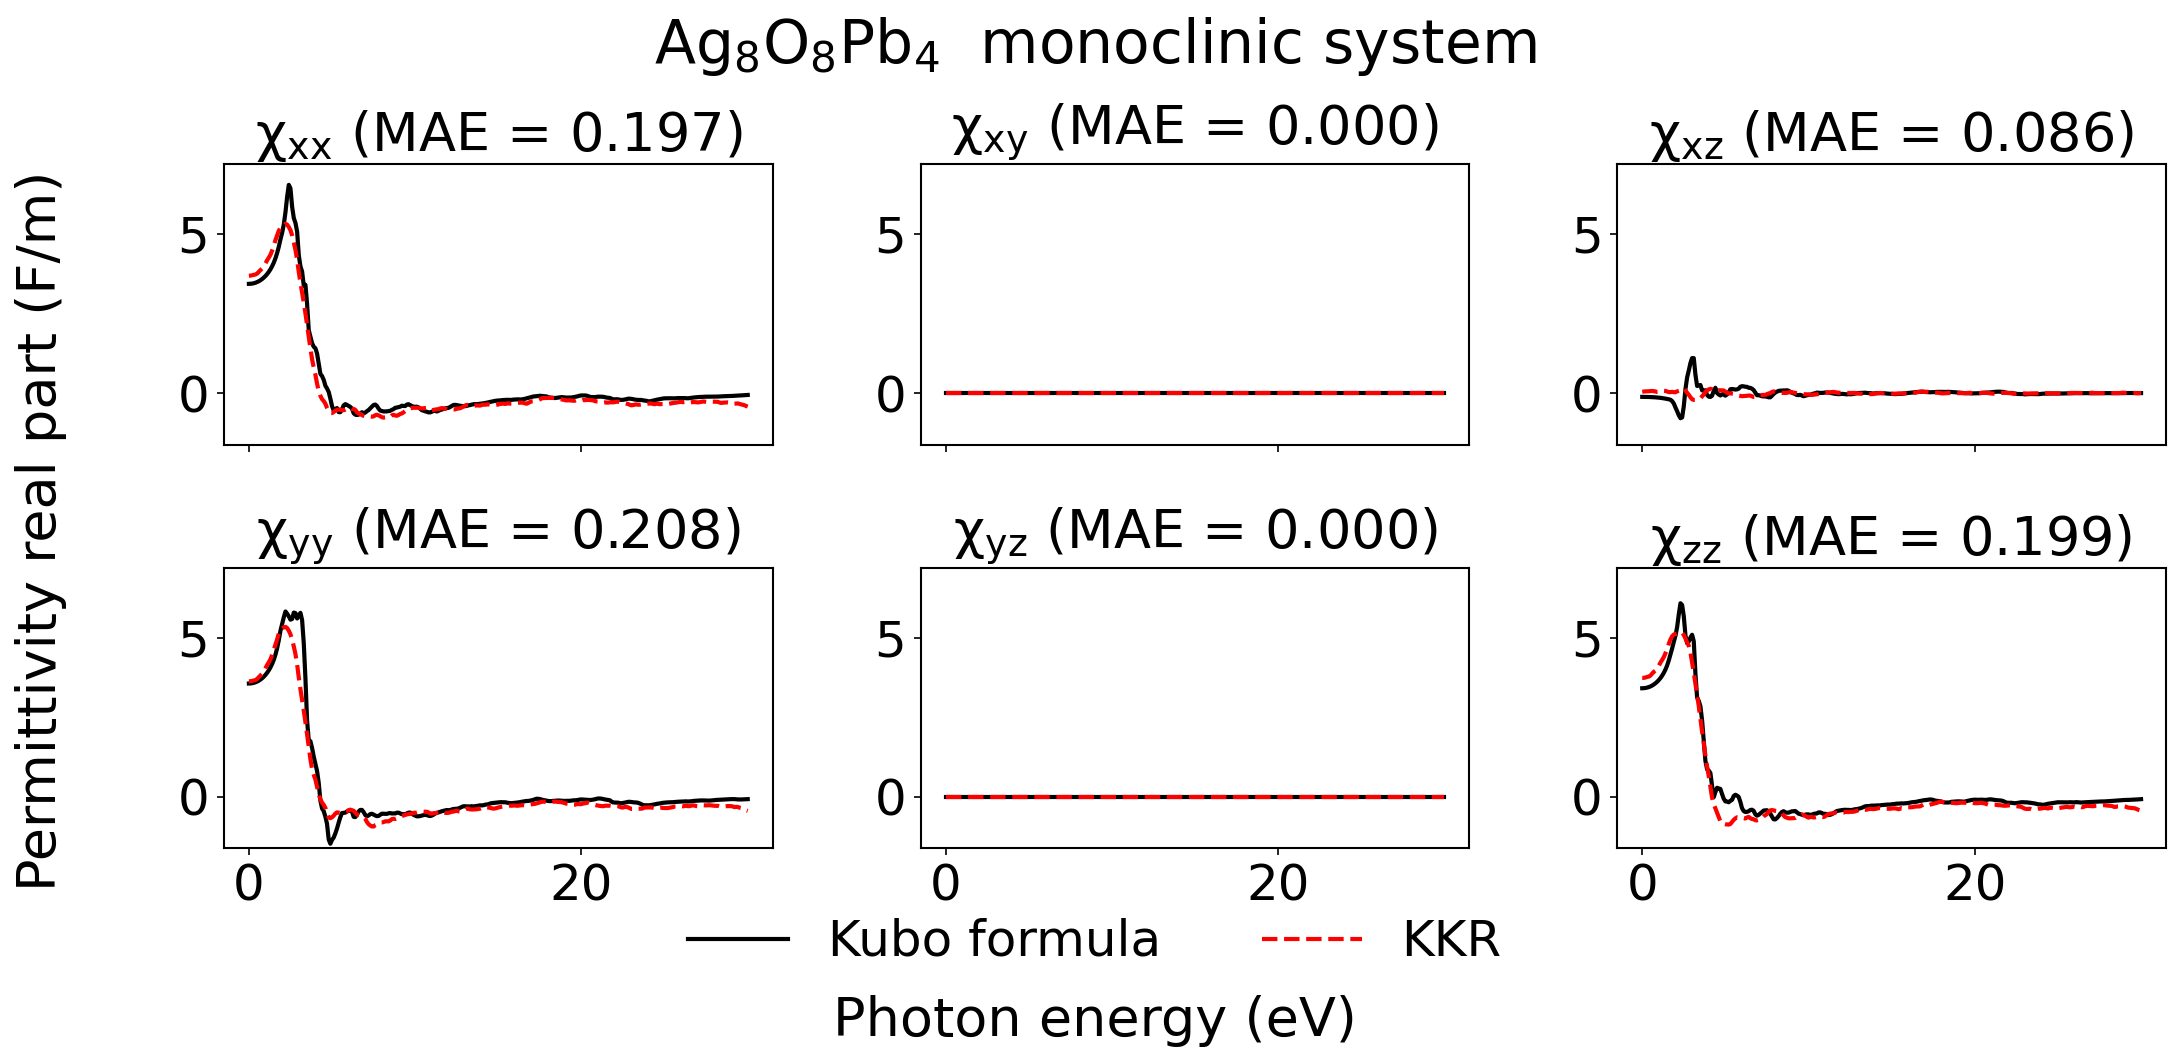

In [11]:
# Choose a row
# row = df[df["formula"] == "Mo3S2Se4"].iloc[0]
# row = df[df["formula"] == "H2Na2O2"].iloc[0]
# row = df[(df["split"] == "Test") & (df["crystal_system"] == "monoclinic")].sample(1).iloc[0]
row = df[df["formula"] == "Ag8O8Pb4"].iloc[0]

# Extract data
omega = row.omega
omega_interp = row.energies_interp
imag_permittivity = row["y_pred_cart"]
real_permittivity = interpolate_matrix(row["real_symmetrized_permittivity"], omega)
real_permittivity_kkr = kramers_kronig_tensor(omega_interp, imag_permittivity)
xyz_list = ['x', 'y', 'z']
fontsize = 24
figsize = (15, 8)

# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True)
axes = axes.flatten()

component_idx = 0
lines = []
labels = []
maes = []
all_vals = np.concatenate([
    real_permittivity[:, np.triu_indices(3)[0], np.triu_indices(3)[1]],
    real_permittivity_kkr[:, np.triu_indices(3)[0], np.triu_indices(3)[1]]
], axis=1)
global_abs_max = np.max(np.abs(all_vals))
global_abs_min = np.min((all_vals))

for i in range(3):
    for j in range(i, 3):
        ax = axes[component_idx]
        comp_label = rf"$\chi_{{{xyz_list[i]}{xyz_list[j]}}}$"

        y1 = real_permittivity[:, i, j]
        y2 = real_permittivity_kkr[:, i, j]

        l1, = ax.plot(omega_interp, y1, color='black', label='Kubo formula', linewidth = 2)
        l2, = ax.plot(omega_interp, y2, linestyle='--', color='red', label='KKR', linewidth =2)

        mae = np.mean(np.abs(y1 - y2))
        maes.append(mae)

        ax.set_ylim(global_abs_min * 1.1, global_abs_max * 1.1)
        ax.set_title(f"{comp_label} (MAE = {mae:.3f})", fontsize=fontsize + 2)

        if component_idx == 0:
            lines.extend([l1, l2])
            labels.extend([l.get_label() for l in (l1, l2)])

        component_idx += 1
# Hide unused subplots if any
for k in range(component_idx, len(axes)):
    fig.delaxes(axes[k])


formula = format_chemical_formula(row["formula"])
crystal_sys = row["crystal_system"]
# Super (global) axis labels
fig.suptitle(rf"${formula}$  {crystal_sys} system",y = 0.93)
fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 2, y=0.07)
fig.supylabel("Permittivity real part (F/m)", fontsize=fontsize + 2)

# Shared legend below all plots
fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=fontsize,  bbox_to_anchor=(0.5, 0.1),frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
plt.show()

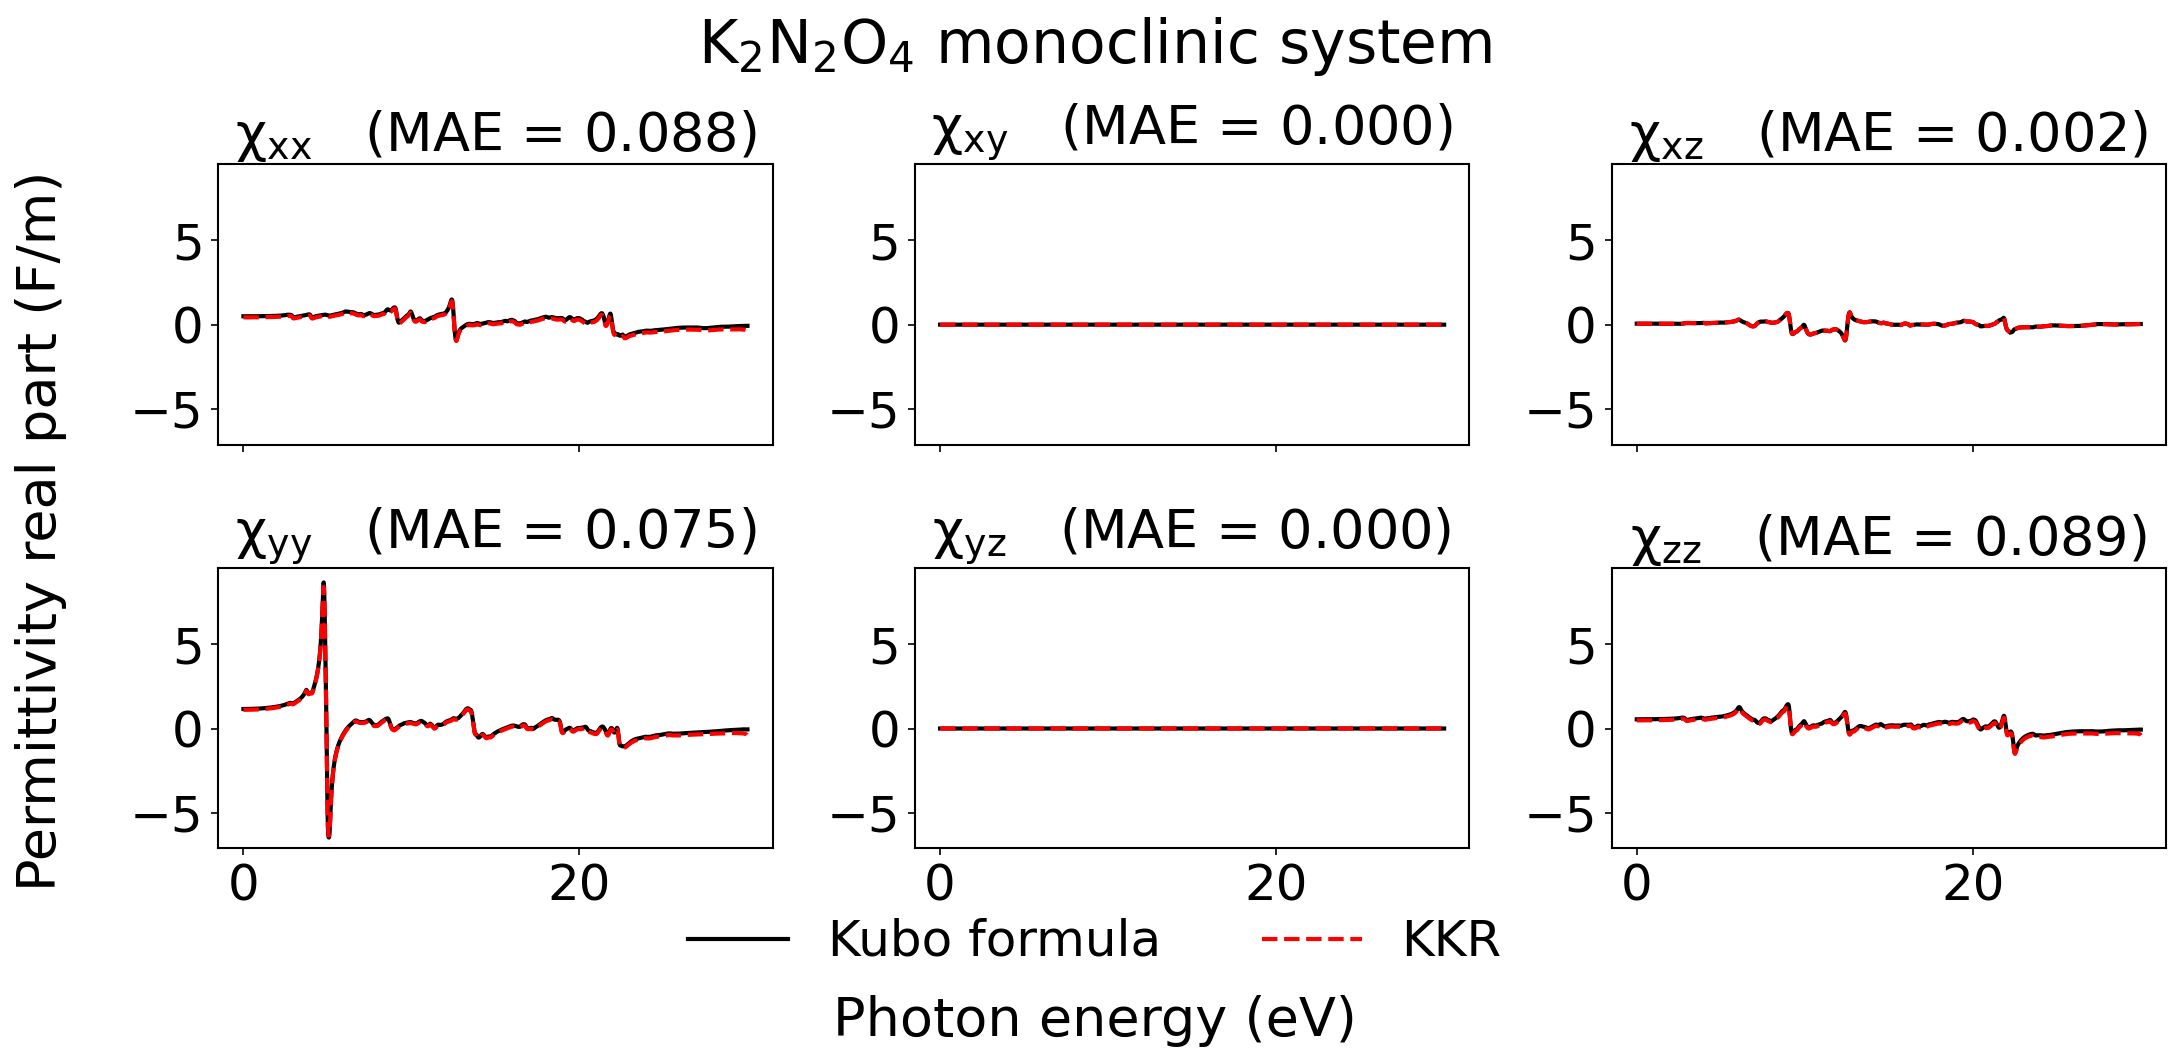

In [12]:
# Extract data
row = df[df.formula == "K2N2O4"].iloc[0]
omega = row.omega
imag_permittivity = row["imag_symmetrized_permittivity"]
real_permittivity = row["real_symmetrized_permittivity"]
real_permittivity_kkr = kramers_kronig_tensor(omega, imag_permittivity)
# Settings
xyz_list = ['x', 'y', 'z']
fontsize = 24
figsize = (15, 8)

# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True)
axes = axes.flatten()

component_idx = 0
lines = []
labels = []
maes = []
all_vals = np.concatenate([
    real_permittivity[:, np.triu_indices(3)[0], np.triu_indices(3)[1]],
    real_permittivity_kkr[:, np.triu_indices(3)[0], np.triu_indices(3)[1]]
], axis=1)
global_abs_max = np.max(np.abs(all_vals))
global_abs_min = np.min((all_vals))
for i in range(3):
    for j in range(i, 3):
        ax = axes[component_idx]
        comp_label = rf"$\chi_{{{xyz_list[i]}{xyz_list[j]}}}$"

        l1, = ax.plot(omega, real_permittivity[:, i, j], color='black', label='Kubo formula', linewidth = 2)
        l2, = ax.plot(omega, real_permittivity_kkr[:, i, j], linestyle='--', color='red', label='KKR', linewidth = 2)
        # Optional: zero line for context
        # ax.axhline(0, color='gray', linestyle=':', linewidth=0.8)
        mae = np.mean(np.abs(real_permittivity[:, i, j] - real_permittivity_kkr[:, i, j]))
        maes.append(mae)
        # Automatically zoom out if the component is near-zero
        ax.set_ylim(global_abs_min * 1.1, global_abs_max * 1.1)

        ax.set_title(f"{comp_label}   (MAE = {mae:.3f})", fontsize=fontsize + 2)

        if component_idx == 0:
            lines.extend([l1, l2])
            labels.extend([l.get_label() for l in (l1, l2)])

        component_idx += 1
# Hide unused subplots if any
for k in range(component_idx, len(axes)):
    fig.delaxes(axes[k])


formula = format_chemical_formula(row["formula"])
crystal_sys = row["crystal_system"]
# Super (global) axis labels
fig.suptitle(rf"${formula}$ {crystal_sys} system", y=0.93)
fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 2, y=0.07)
fig.supylabel("Permittivity real part (F/m)", fontsize=fontsize + 2)

# Shared legend below all plots
fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=fontsize,  bbox_to_anchor=(0.5, 0.1),frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
plt.show()
